# 3일차 실습과제

- 뉴욕시내에서도 요금에는 0이하의 값과 500가까운 요금도 있음
- 당뇨병의 정확도가 너무 낮음

In [1]:
# 모듈 로딩
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import platform
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from collections import Counter
from sklearn.linear_model import LogisticRegression

In [2]:
## 한글폰트
if platform.system()=='Windows':
    plt.rc('font',family='Malgun Gothic')
else:
    plt.rc('font',family='AppleGothic')

## 1) 회귀(Refression)
  - 거리에 따른 택시요금 예측
  - 뉴욕시내에서 승/하차의 경우만

In [3]:
# 데이터 준비(5만개 행)
taxi_df_50000=pd.read_csv('train.csv',nrows=50000,parse_dates=['pickup_datetime'])
print(taxi_df_50000)

                                 key  fare_amount           pickup_datetime  \
0        2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1        2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2       2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3        2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4      2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   
...                              ...          ...                       ...   
49995    2013-06-12 23:25:15.0000004         15.0 2013-06-12 23:25:15+00:00   
49996    2015-06-22 17:19:18.0000007          7.5 2015-06-22 17:19:18+00:00   
49997   2011-01-30 04:53:00.00000063          6.9 2011-01-30 04:53:00+00:00   
49998   2012-11-06 07:09:00.00000069          4.5 2012-11-06 07:09:00+00:00   
49999    2010-01-13 08:13:14.0000007         10.9 2010-01-13 08:13:14+00:00   

       pickup_longitude  pickup_latitude  dropoff_l

In [4]:
# key열은 pickup_datetime와 같으므로 삭제
taxi_df_50000_new=taxi_df_50000.iloc[:,1:]

In [5]:
# 데프 정보 확인
taxi_df_50000_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   fare_amount        50000 non-null  float64            
 1   pickup_datetime    50000 non-null  datetime64[ns, UTC]
 2   pickup_longitude   50000 non-null  float64            
 3   pickup_latitude    50000 non-null  float64            
 4   dropoff_longitude  50000 non-null  float64            
 5   dropoff_latitude   50000 non-null  float64            
 6   passenger_count    50000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 2.7 MB


In [6]:
# 열이름 확인
taxi_df_50000_new.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

- fare_amount: 요금
- pickup_datetime: 승차 시간
- pickup_longitude: 승차 경도
- pickup_latitude: 승차 위도
- dropoff_longitude: 하차 경도
- dropoff_latitude: 하차 위도
- passenger_count: 승객 수

In [7]:
# 결측치 및 이상치 체크
taxi_df_50000_new.isnull().sum()

# 아무 결측값 없으므로 그대로 진행

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

c:\ProgramData\Anaconda3\envs\EV_PY39\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
c:\ProgramData\Anaconda3\envs\EV_PY39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


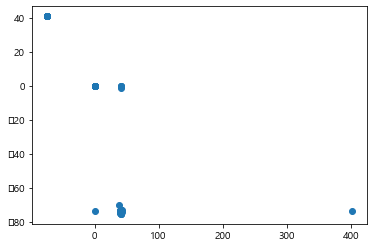

In [8]:
# 뉴욕시 승차 산점도
plt.scatter(taxi_df_50000_new.pickup_latitude,taxi_df_50000_new.pickup_longitude)

- 확인해본 결과 x축인 위도는 40대, y축인 경도는 -70대 정도인 것으로 보인다고 설정하고 진행

In [9]:
# 뉴욕시 택시 데이터(승차가 뉴욕이 아닌거 지움)
ny_taxi_df=taxi_df_50000_new[((taxi_df_50000_new.pickup_latitude>=40.49) & (taxi_df_50000_new.pickup_latitude<=40.92)) & ((taxi_df_50000_new.pickup_longitude<=-73.68) & (taxi_df_50000_new.pickup_longitude>=-74.27))]
ny_taxi_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...
49995,15.0,2013-06-12 23:25:15+00:00,-73.999973,40.748531,-74.016899,40.705993,1
49996,7.5,2015-06-22 17:19:18+00:00,-73.984756,40.768211,-73.987366,40.760597,1
49997,6.9,2011-01-30 04:53:00+00:00,-74.002698,40.739428,-73.998108,40.759483,1
49998,4.5,2012-11-06 07:09:00+00:00,-73.946062,40.777567,-73.953450,40.779687,2


In [10]:
# 뉴욕시 택시 데이터(하차가 뉴욕이 아닌거 지움)
ny_taxi_df=ny_taxi_df[((ny_taxi_df.dropoff_latitude>=40.49) & (ny_taxi_df.dropoff_latitude<=40.92)) & ((ny_taxi_df.dropoff_longitude<=-73.68) & (ny_taxi_df.dropoff_longitude>=-74.27))]
ny_taxi_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...
49995,15.0,2013-06-12 23:25:15+00:00,-73.999973,40.748531,-74.016899,40.705993,1
49996,7.5,2015-06-22 17:19:18+00:00,-73.984756,40.768211,-73.987366,40.760597,1
49997,6.9,2011-01-30 04:53:00+00:00,-74.002698,40.739428,-73.998108,40.759483,1
49998,4.5,2012-11-06 07:09:00+00:00,-73.946062,40.777567,-73.953450,40.779687,2


In [11]:
# 데이터에 위도/경도가 제대로 들어갔는지 확인
print(f"승차 경도 최대값 {max(ny_taxi_df['pickup_longitude'])}")
print(f"승차 경도 최소값 {min(ny_taxi_df['pickup_longitude'])}")
print(f"승차 위도 최대값 {max(ny_taxi_df['pickup_latitude'])}")
print(f"승차 위도 최소값 {min(ny_taxi_df['pickup_latitude'])}")
print(f"하차 경도 최대값 {max(ny_taxi_df['dropoff_longitude'])}")
print(f"하차 경도 최소값 {min(ny_taxi_df['dropoff_longitude'])}")
print(f"하차 위도 최대값 {max(ny_taxi_df['dropoff_latitude'])}")
print(f"하차 위도 최소값 {min(ny_taxi_df['dropoff_latitude'])}")


승차 경도 최대값 -73.68817
승차 경도 최소값 -74.248263
승차 위도 최대값 40.91829
승차 위도 최소값 40.522263
하차 경도 최대값 -73.699185
하차 경도 최소값 -74.241953
하차 위도 최대값 40.911983
하차 위도 최소값 40.529306


In [12]:
# 새로운 열을 만들기
ny_taxi_df['distance']=((ny_taxi_df['pickup_longitude']-ny_taxi_df['dropoff_longitude'])**2+(ny_taxi_df['pickup_latitude']-ny_taxi_df['dropoff_latitude'])**2)**0.5
ny_taxi_df

C:\Users\whrjs\AppData\Local\Temp\ipykernel_21028\3042579735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ny_taxi_df['distance']=((ny_taxi_df['pickup_longitude']-ny_taxi_df['dropoff_longitude'])**2+(ny_taxi_df['pickup_latitude']-ny_taxi_df['dropoff_latitude'])**2)**0.5


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.009436
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,0.079696
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0.013674
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,0.025340
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,0.019470
...,...,...,...,...,...,...,...,...
49995,15.0,2013-06-12 23:25:15+00:00,-73.999973,40.748531,-74.016899,40.705993,1,0.045782
49996,7.5,2015-06-22 17:19:18+00:00,-73.984756,40.768211,-73.987366,40.760597,1,0.008049
49997,6.9,2011-01-30 04:53:00+00:00,-74.002698,40.739428,-73.998108,40.759483,1,0.020574
49998,4.5,2012-11-06 07:09:00+00:00,-73.946062,40.777567,-73.953450,40.779687,2,0.007686


In [13]:
# 요금(fare_amount)을 target으로 거리(distance)를 input으로
input=np.array(ny_taxi_df['distance']).reshape(-1,1)
target=np.array(ny_taxi_df['fare_amount']).reshape(-1,1)

### 선형회귀

In [14]:
# 훈련/테스트 데이터 나누기
train_input,test_input,train_target,test_target=train_test_split(input,target,random_state=2,test_size=0.8)

In [15]:
# 모델 생성
model=LinearRegression()

In [16]:
# 모델 훈련
model.fit(train_input,train_target)

LinearRegression()

In [17]:
# 모델 평가
model.score(train_input,train_target)

0.7396970042774

In [18]:
# 모델 예측값
model.predict(test_input)

array([[ 6.37103926],
       [ 6.17496692],
       [ 5.12113716],
       ...,
       [ 9.41690547],
       [13.84522424],
       [ 5.23122701]])

In [19]:
# 테스트 데이터 평가
model.score(test_input,test_target)

0.7754098108376646

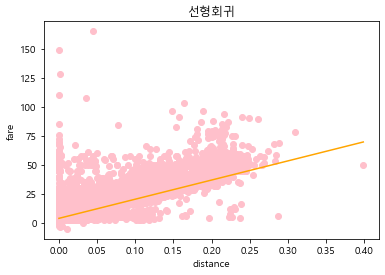

In [20]:
# 선형회귀 산점도
plt.scatter(input,target,color='pink')
plt.plot([min(input),max(input)],[min(model.predict(test_input)),max(model.predict(test_input))],color='orange')
plt.title('선형회귀')
plt.xlabel('distance')
plt.ylabel('fare')
plt.show()

### 다항회귀

In [21]:
# 다항 데이터 만들기
input_poly=np.column_stack((input**2,input)).reshape(-1,2)

train_input_poly,test_input_poly,train_target,test_target=train_test_split(input_poly,target,random_state=42)

In [22]:
# 모델 생성
model=LinearRegression()

In [23]:
# 모델훈련
model.fit(train_input_poly,train_target)

LinearRegression()

In [24]:
# 모델평가
model.score(train_input_poly,train_target)

0.7595808768993105

In [25]:
# 모델예측
model.predict(test_input_poly)

array([[35.60163444],
       [ 9.10322856],
       [ 8.27336909],
       ...,
       [ 6.52576736],
       [11.93442086],
       [ 8.52822278]])

In [26]:
# 회귀계수 및 절편
print(f"회귀계수 : {model.coef_}, 절편 {model.intercept_}")

회귀계수 : [[-20.58260938 218.54581153]], 절편 [3.94068341]


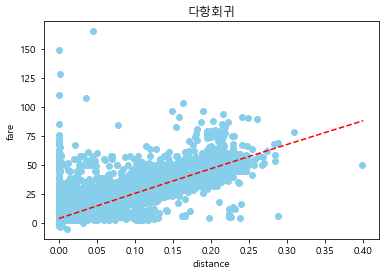

In [27]:
# 다항 회귀의 산점도
point=np.arange(0,0.41,0.01)
plt.scatter(input,target,color='skyblue')
plt.plot(point,-20.58260938*(point**2)+218.54581153*point+3.94068341,linestyle='--',color='red')
plt.title('다항회귀')
plt.xlabel('distance')
plt.ylabel('fare')
plt.show()

## 2) 분류(Classification)
- 당뇨 발생여부
- 당뇨병 발병확률이 XX%입니다.

In [28]:
# 데이터불러오기
dia_df=pd.read_csv('diabetes.csv')
dia_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


- Pregnancies: 임신
- Glucose: 포도당
- BloodPressure: 혈압
- SkinThickness: 피부 두께
- Insulin: 인슐린
- BMI: 체질량 지수
- DiabetesPedigreeFunction: 당뇨병 내력
- Age: 나이
- Outcome: 당뇨병 여부(0: 아님, 1: 당뇨병 맞음)

In [29]:
# 당뇨병 환자와 아닌 사람 비교
Counter(dia_df.Outcome)

Counter({1: 268, 0: 500})

In [30]:
# 데이터 정보
dia_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [31]:
# 데이터 요약 통계량
dia_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [32]:
# 결측치 확인
dia_df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [33]:
# 상관계수
dia_df.corr()

# 당뇨병 여부와 제일 상관 있어보이는 포도당(Glucose)이 0.4로 별로 높지 않아서 내가 임의로 정해봄

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


- BloodPressure(혈압), Insulin(인슐린), DiabetesPedigreeFunction(가족내력), Age(나이)만 input정하고 Outcome을 target으로 잡음

### 로지스틱 회귀

In [34]:
# input/target 정하기
input=np.array(dia_df[['BloodPressure','Insulin','DiabetesPedigreeFunction','Age']]).reshape(-1,4)
target=np.array(dia_df['Outcome'])

In [35]:
# 훈련/테스트 데이터 나누기
train_input,test_input,train_target,test_target=train_test_split(input,target,random_state=42)

In [36]:
# 모델생성
model=LogisticRegression()

In [37]:
# 모델훈련
model.fit(train_input,train_target)

LogisticRegression()

In [38]:
# 모델평가
model.score(train_input,train_target)

# 임의로 잡은 열데이터라고 그런지 정확도가 많이 낮음

0.6753472222222222

In [39]:
# 모델예측
model.predict(test_input)

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0], dtype=int64)

In [40]:
# 테스트 데이터로 정확도 확인
print(f"테스트 데이터의 정확도는 {model.score(test_input,test_target)}")

# 임의로 잡은 열데이터라고 그런지 정확도가 많이 낮음

테스트 데이터의 정확도는 0.609375


In [41]:
# 새로운 값으로 당뇨병 여부 예측하기
## 혈압: 80, 인슐린: 20, 가족내력: 0.5, 나이: 60
print(f"당뇨병이 {'발병' if model.predict([[80,20,0.5,60]])==1 else '발병 안'}했습니다.")

## 혈압: 100, 인슐린: 10, 가족내력: 0.1, 나이: 20
print(f"당뇨병이 {'발병' if model.predict([[100,10,0.1,20]])==1 else '발병 안'}했습니다.")

## 혈압: 150, 인슐린: 100, 가족내력: 1, 나이: 30
print(f"당뇨병이 {'발병' if model.predict([[150,100,1,30]])==1 else '발병 안'}했습니다.")

## 혈압: 150, 인슐린: 200, 가족내력: 2, 나이: 50
print(f"당뇨병이 {'발병' if model.predict([[100,200,2,50]])==1 else '발병 안'}했습니다.")

## 혈압: 100, 인슐린: 300, 가족내력: 1, 나이: 50
print(f"당뇨병이 {'발병' if model.predict([[100,300,1,50]])==1 else '발병 안'}했습니다.")

## 혈압: 100, 인슐린: 10, 가족내력: 0.8, 나이: 40
print(f"당뇨병이 {'발병' if model.predict([[100,10,0.8,40]])==1 else '발병 안'}했습니다.")

## 혈압: 80, 인슐린: 30, 가족내력: 1, 나이: 35
print(f"당뇨병이 {'발병' if model.predict([[80,30,1,35]])==1 else '발병 안'}했습니다.")

당뇨병이 발병했습니다.
당뇨병이 발병 안했습니다.
당뇨병이 발병 안했습니다.
당뇨병이 발병했습니다.
당뇨병이 발병했습니다.
당뇨병이 발병 안했습니다.
당뇨병이 발병 안했습니다.


In [42]:
print(f"{model.predict_proba([[80,30,1,35]])[[0]]}")

[[0.57554228 0.42445772]]


In [43]:
model.predict_proba([[80,30,1,35]])[0,0]

0.5755422758637223